This script analyze the output of O3 box model with source apportionment technique. The goal of this script is to find the O3 contribution from different source of VOCs from the box model for Redlands, CA

In [8]:
import os, importlib, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import join, isfile
sys.path.append('../../code/src')
#importlib.reload(sys.modules['box_model_source_apportionment'])
from box_model_source_apportionment import treat_box_model_output

In [9]:
df_all = pd.DataFrame(columns=['Date','Time','O3','O3_X1','O3_X2','O3_X3',
                                 'O3_X4','O3_X5','O3_X6',
                                 'O3_X7','O3_X8','O3_X9'])
folderpath = '../../data/intermediate/box_model_output_bgX/'
filelist = [f for f in listdir(folderpath) if 
            isfile(join(folderpath, f))]
filelist = [s for s in filelist if 'results' in s ]

for file in filelist:
    filepath = folderpath + file
    df = treat_box_model_output(filepath)
    df_all = pd.concat([df_all, df], ignore_index=True)
df_all.iloc[:,2:] = df_all.iloc[:,2:].astype(float)

In [10]:
df_O3_source_avg = pd.DataFrame(df_all[df_all['Time']==180].iloc[:,2:].mean(axis=0))
df_O3_source_avg.columns = ['Value']

# Subtract the initial O3 from final O3_vanilla
O3_init_avg = df_all[df_all['Time']==0].iloc[:,2:].mean(axis=0)[0]
df_O3_source_avg.iloc[0,0] = df_O3_source_avg.iloc[0,0] - O3_init_avg

# calculate the percentage  to sum
df_O3_source_avg['Percentage'] = df_O3_source_avg['Value']/df_O3_source_avg['Value'].sum()*100

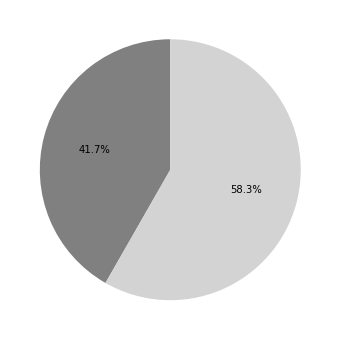

In [11]:
O3_not_in_PMF = df_O3_source_avg.loc['O3','Percentage']
O3_in_PMF = 100 - O3_not_in_PMF
pie = [O3_not_in_PMF, O3_in_PMF]

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.pie(pie, autopct='%1.1f%%',
        shadow=False, startangle=90, colors = ['grey','lightgrey'])
fig.set_facecolor('white')

In [12]:
df_O3_source_novanilla = df_O3_source_avg.iloc[1:,:]
df_O3_source_novanilla['Precentage'] = \
    df_O3_source_novanilla['Value']/df_O3_source_novanilla['Value'].sum()

# reorder source of O3 to match the order in OFP analysis
idx = ['O3_X1','O3_X3','O3_X5','O3_X4','O3_X9','O3_X8','O3_X6','O3_X7','O3_X2']
df_O3_source_novanilla = df_O3_source_novanilla.loc[idx,:]

C:\Users\Shenglun\AppData\Local\Temp/ipykernel_16780/2570864992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_O3_source_novanilla['Precentage'] = \


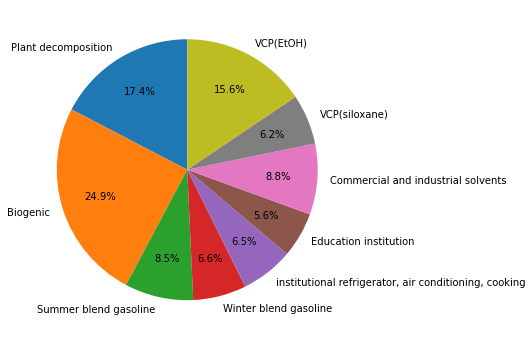

In [13]:
# make pie chart (no vanilla)
fig, ax=plt.subplots(1, figsize=(6, 6))
factor_name = ['Plant decomposition', 'Biogenic', 'Summer blend gasoline',
               'Winter blend gasoline', 'institutional refrigerator, air conditioning, cooking', 'Education institution', 'Commercial and industrial solvents', 
               'VCP(siloxane)', 'VCP(EtOH)']

ax.pie(df_O3_source_novanilla['Percentage'], labels=factor_name, 
       autopct='%.1f%%', pctdistance=0.7,shadow=False, startangle=90, textprops={'fontsize': 10})
fig.set_facecolor('white')


<AxesSubplot:xlabel='Date'>

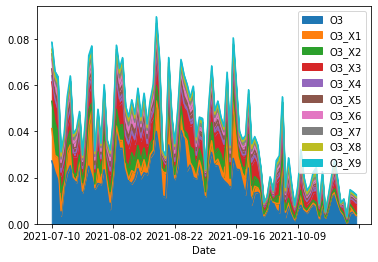

In [14]:
# plot stacked time series
df_plot = df_all.loc[df_all['Time']==180, ['Date','O3','O3_X1','O3_X2','O3_X3','O3_X4',
                      'O3_X5','O3_X6','O3_X7','O3_X8','O3_X9']].reset_index(drop=True)
df_plot['O3'] = df_plot['O3'] - df_all[df_all['Time']==0].reset_index()['O3']
df_plot = df_plot.set_index('Date')

df_plot.plot.area()

In [15]:
# plot correctation table for each source
df_O3_source_novanilla

,Value,Percentage,Precentage
O3_X1,0.004133,10.117454,0.173622
O3_X3,0.005920,14.490462,0.248665
O3_X5,0.002025,4.955865,0.085046
O3_X4,0.001570,3.843216,0.065952
O3_X9,0.001550,3.794359,0.065113
O3_X8,0.001334,3.264699,0.056024
O3_X6,0.002091,5.117586,0.087821
O3_X7,0.001479,3.619146,0.062107
O3_X2,0.003705,9.070223,0.155650
